In [1]:
# imports
import os, sys
import re
import ast
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import csv 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asheshchoudhury/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#from googlesearch import search
#from google import google as g
#from textblob import TextBlob
#import texttable as tt
from time import sleep

In [4]:
# Start timer to get total time for running all code
t0 = datetime.datetime.now()
#Train
#df=pd.read_csv("C:/Users/asheshchoudhury/Desktop/Capstone-new/w210-final/data/ExtractedTweets.csv")
#df=pd.read_csv('/home/asheshchoudhury/ExtractedTweets.csv')
#df=pd.read_csv('/home/asheshchoudhury/senate-labeled-v2.csv')
mylist = []

for chunk in  pd.read_csv('/home/asheshchoudhury/senate-labeled-v2.csv', chunksize=20):
    mylist.append(chunk)

df = pd.concat(mylist, axis= 0)
del mylist

#Check all political parties
print('List of Parties before filtering')
df['party'].unique()
#take only D and R
df = df.loc[(df['party'] == 'Republican') | (df['party'] == 'Democratic')]
print('List of Parties after filtering')
df['party'].unique()
#Add statement lenght as 1 or 2 large oulier can cause abort the program
df['statement_length'] = df['statement'].str.len()
df['statement_length'].describe()
#Take reasonable(>25 percentile, <75 percentile) statement length , else huge statment lengt will crash the system
statement_lenght_75_percentile = 1881
statement_lenght_25_percentile = 86
df = df.loc[(df['statement_length'] <= statement_lenght_75_percentile)]
df = df.loc[(df['statement_length'] >= statement_lenght_25_percentile)]
df['statement_length'].describe()
df['date'].describe()
#input_percentage_date = 0.1
#no_of_input = int(len(df)*input_percentage_date)
#df=df[:no_of_input]
#Sneak peak
#df.head()
len(df)



List of Parties before filtering


array(['Republican', 'Democratic', 'Independent Democrat', 'Independent'],
      dtype=object)

List of Parties after filtering


array(['Republican', 'Democratic'], dtype=object)

count    546549.000000
mean       1922.050253
std        4364.634689
min           3.000000
25%          86.000000
50%         254.000000
75%        1881.000000
max      956247.000000
Name: statement_length, dtype: float64

count    281651.000000
mean        441.393853
std         437.109037
min          86.000000
25%         134.000000
50%         245.000000
75%         597.000000
max        1881.000000
Name: statement_length, dtype: float64

count    2.816510e+05
mean     2.004185e+07
std      6.601025e+04
min      1.995010e+07
25%      1.999022e+07
50%      2.003093e+07
75%      2.009051e+07
max      2.019102e+07
Name: date, dtype: float64

281651

In [5]:
#EDA
df_1995_2001 = df.loc[(df['date'] <= 20010101)]
df_2001_2005 = df.loc[(df['date'] >= 20010101) & (df['date'] <= 20050101)]
df_2005_2009 = df.loc[(df['date'] >= 20050101) & (df['date'] <= 20090101)]
df_2009_2013 = df.loc[(df['date'] >= 20090101) & (df['date'] <= 20130101)]
df_2013_2017 = df.loc[(df['date'] >= 20130101) & (df['date'] <= 20170101)]
df_2017_2019 = df.loc[(df['date'] >= 20170101)]
                           

In [6]:
print('Total no. of statements in original input senate dataset :', len(df))
print('Total no. of Republican statements in original input senate dataset :' ,len(df.loc[(df['party'] == 'Republican')]))
print('Total no. of Democratic statements in original input senate dataset:' ,len(df.loc[(df['party'] == 'Democratic')]))
print('% of Republican statements in original input senate dataset :', "%.2f" %(len(df.loc[(df['party'] == 'Republican')])/len(df)*100))

Total no. of statements in original input senate dataset : 281651
Total no. of Republican statements in original input senate dataset : 145760
Total no. of Democratic statements in original input senate dataset: 135891
% of Republican statements in original input senate dataset : 51.75


In [7]:

no_of_republican_statements = [len(df_1995_2001.loc[(df_1995_2001['party'] == 'Republican')]),len(df_2001_2005.loc[(df_2001_2005['party'] == 'Republican')]),len(df_2005_2009.loc[(df_2005_2009['party'] == 'Republican')]),len(df_2009_2013.loc[(df_2009_2013['party'] == 'Republican')]),len(df_2013_2017.loc[(df_2013_2017['party'] == 'Republican')]),len(df_2017_2019.loc[(df_2017_2019['party'] == 'Republican')])]
no_of_democrat_statements = [len(df_1995_2001.loc[(df_1995_2001['party'] == 'Democratic')]),len(df_2001_2005.loc[(df_2001_2005['party'] == 'Democratic')]),len(df_2005_2009.loc[(df_2005_2009['party'] == 'Democratic')]),len(df_2009_2013.loc[(df_2009_2013['party'] == 'Democratic')]),len(df_2013_2017.loc[(df_2013_2017['party'] == 'Democratic')]),len(df_2017_2019.loc[(df_2017_2019['party'] == 'Democratic')])]

no_of_republican_statements
no_of_democrat_statements



[59263, 27670, 24393, 11823, 13053, 9559]

[39506, 31139, 24649, 23872, 12835, 3914]

<Figure size 1800x720 with 0 Axes>

Text(0, 0.5, 'No. of Statements')

[Text(0, 0, '1995-2001'),
 Text(0, 0, '2001-05'),
 Text(0, 0, '2005-09'),
 Text(0, 0, '2009-13'),
 Text(0, 0, '2013-17'),
 Text(0, 0, '2017-19')]

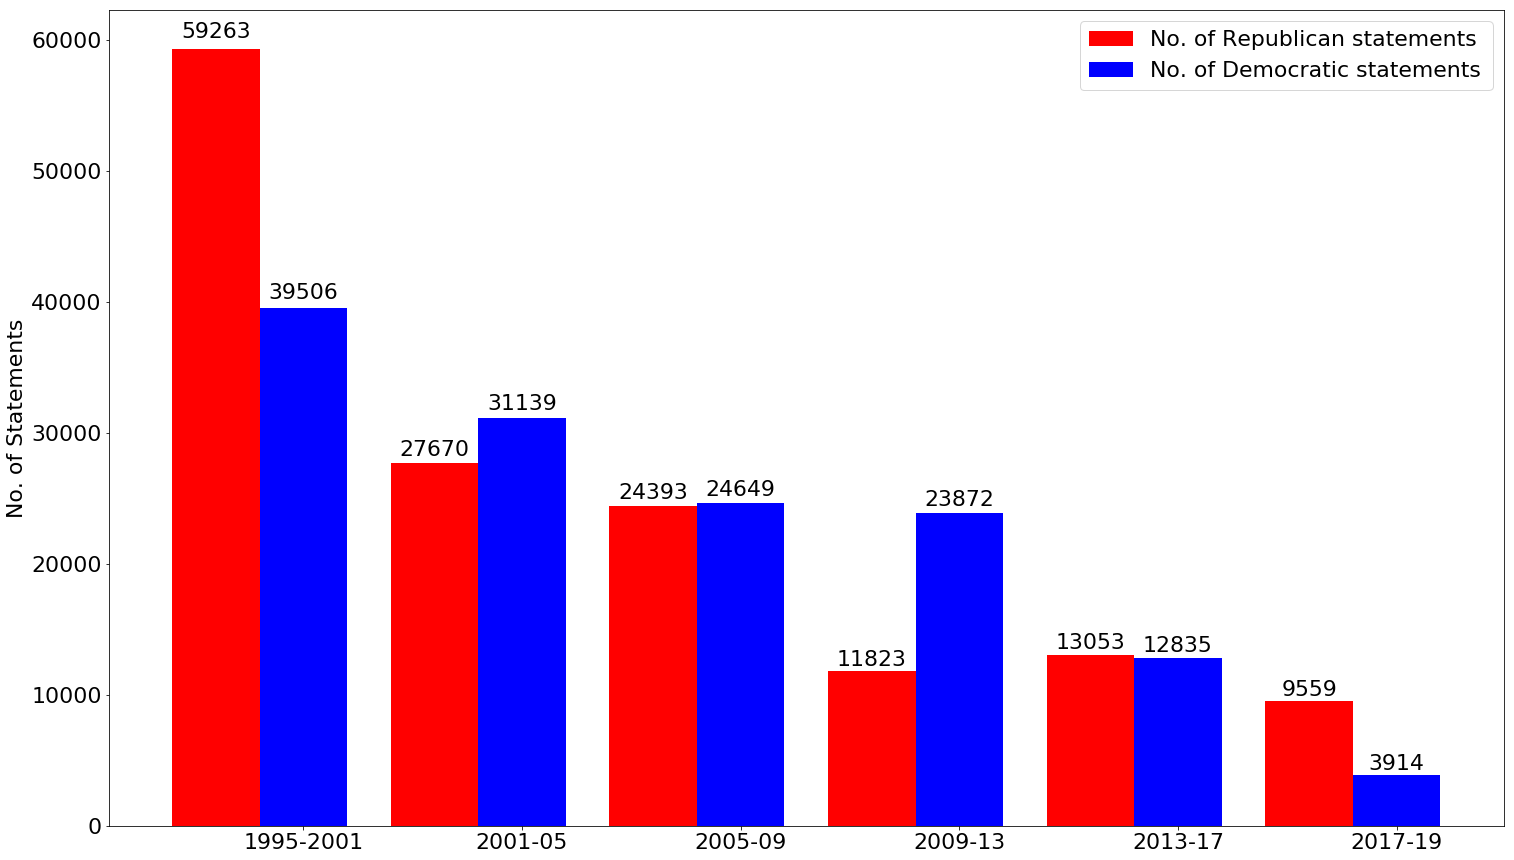

<Figure size 1800x720 with 0 Axes>

In [8]:
N = 6
width = 0.4
ind = np.arange(N)  # the x locations for the groups

fig = plt.figure(figsize = (25, 15))
plt.figure(figsize = (25, 10))
plt.rcParams.update({'font.size': 22})
ax = fig.add_subplot(111)


yvals = no_of_republican_statements
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = no_of_democrat_statements
rects2 = ax.bar(ind+width, zvals, width, color='b')


ax.set_ylabel('No. of Statements')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('1995-2001', '2001-05', '2005-09', '2009-13','2013-17','2017-19') )
ax.legend( (rects1[0], rects2[0]), ('No. of Republican statements ', 'No. of Democratic statements') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.01*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [9]:
input_data_percentage = 0.1
n = int(len(df)*input_data_percentage/12)

In [10]:
df_1995_2001_R = df_1995_2001.loc[(df_1995_2001['party'] == 'Republican')][:39506]
df_1995_2001_D = df_1995_2001.loc[(df_1995_2001['party'] == 'Democratic')]
df_2001_2005_R = df_2001_2005.loc[(df_2001_2005['party'] == 'Republican')]
df_2001_2005_D = df_2001_2005.loc[(df_2001_2005['party'] == 'Democratic')][:27670]
df_2005_2009_R = df_2005_2009.loc[(df_2005_2009['party'] == 'Republican')]
df_2005_2009_D = df_2005_2009.loc[(df_2005_2009['party'] == 'Democratic')][:24393]
df_2009_2013_R = df_2009_2013.loc[(df_2009_2013['party'] == 'Republican')]
df_2009_2013_D = df_2009_2013.loc[(df_2009_2013['party'] == 'Democratic')][:11823]
df_2013_2017_R = df_2013_2017.loc[(df_2013_2017['party'] == 'Republican')][:12835]
df_2013_2017_D = df_2013_2017.loc[(df_2013_2017['party'] == 'Democratic')]
df_2017_2019_R = df_2017_2019.loc[(df_2017_2019['party'] == 'Republican')][:3914]
df_2017_2019_D = df_2017_2019.loc[(df_2017_2019['party'] == 'Democratic')]

df = pd.concat([df_1995_2001_R[:n],df_1995_2001_D[:n],df_2001_2005_R[:n],df_2001_2005_D[:n],df_2005_2009_R[:n],df_2005_2009_D[:n]])
df = pd.concat([df,df_2009_2013_R[:n],df_2009_2013_D[:n],df_2013_2017_R[:n],df_2013_2017_D[:n],df_2017_2019_R[:n],df_2017_2019_D[:n]])
print('Total no. of statements in balanced input senate dataset :' ,len(df))
print('Total no. of Republican statements in balanced input senate dataset :' ,len(df.loc[(df['party'] == 'Republican')]))
print('Total no. of Democratic statements in balanced input senate dataset:' ,len(df.loc[(df['party'] == 'Democratic')]))
print('% of Republican statements in balanced input senate dataset :', "%.2f" %(len(df.loc[(df['party'] == 'Republican')])/len(df)*100))


Total no. of statements in balanced input senate dataset : 28164
Total no. of Republican statements in balanced input senate dataset : 14082
Total no. of Democratic statements in balanced input senate dataset: 14082
% of Republican statements in balanced input senate dataset : 50.00


In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['statement'])
word_index = tokenizer.word_index
#len(word_index)
print('Found %s unique tokens.'% len(word_index))
print('Found {} unique tokens.' .format(len(word_index)))
#X = tokenizer.texts_to_sequences(df['Speech text'])
#X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
#print('Shape of data tensor:', X.shape)
df['Party_numeric D=0 R=1'] = np.where(df['party'] =="Democratic", 0, 1)
df.head()

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

Found 27589 unique tokens.
Found 27589 unique tokens.


,date,party,statement,statement_length,Party_numeric D=0 R=1
2,19950104,Republican,Mr. President I send a resolution to the desk....,257,1
5,19950104,Republican,Mr. President I ask unanimous consent that the...,411,1
29,19950104,Republican,Mr. President I have been pleased to listen to...,1094,1
32,19950104,Republican,Reserving the right to object Mr. President. J...,323,1
33,19950104,Republican,And when all time is used or yielded back is t...,139,1


In [12]:
def remove_special_characters(text, remove_digits=False):
    # Remove special characters from text
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [13]:
#import spacy
#nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)


#def lemmatize_text(text):
    # Get base form for word variants (i.e. running ==> run, cats ==> cat, etc.)
#    text = nlp(text)
#    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#    return text

In [14]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer1 = ToktokTokenizer()
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Remove words 'no' and 'not' from stopword list as these may change meaning of words/phrases
stopword_list = nltk.corpus.stopwords.words('english')
for word in ['no', 'not', 'he', 'she', 'his', 'her', 'hers']:
    stopword_list.remove(word)

# Add characters not captured in special character removal to stop list
stopword_list += ['[', ']', "\\",'mr','mrs','president']                     

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer1.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [15]:
import unicodedata

clean_text = []

for text in df['statement']:
    # Remove accent characters => Expand Contractions => Remove special characters => Lammatize Text => Remove Stop Words
    no_accent_chars = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #expanded_text = expand_contractions(no_accent_chars)
    expanded_text = no_accent_chars 
    no_special_chars = remove_special_characters(expanded_text, remove_digits=False)
    #lem_text = lemmatize_text(no_special_chars)
    #filtered_text = remove_stopwords(lem_text)
    filtered_text = remove_stopwords(no_special_chars)
    
    # Make all text lowercase
    lowercase_text = filtered_text.lower()
    
    # Split text into list of words
    words = lowercase_text.split()
    clean_text.append(words)

# Add cleaned text to dataframe
df['clean_statement'] = clean_text
df.head()

,date,party,statement,statement_length,Party_numeric D=0 R=1,clean_statement
2,19950104,Republican,Mr. President I send a resolution to the desk....,257,1,"[send, resolution, desk, vice, clerk, report, ..."
5,19950104,Republican,Mr. President I ask unanimous consent that the...,411,1,"[ask, unanimous, consent, text, bill, printed,..."
29,19950104,Republican,Mr. President I have been pleased to listen to...,1094,1,"[pleased, listen, statement, distinguished, se..."
32,19950104,Republican,Reserving the right to object Mr. President. J...,323,1,"[reserving, right, object, clarification, prev..."
33,19950104,Republican,And when all time is used or yielded back is t...,139,1,"[time, used, yielded, back, next, order, busin..."


In [16]:
# Set variables for dependent and independent variables
target = df['Party_numeric D=0 R=1']
data = df['clean_statement'].values

In [17]:
# Create Bigrams as Certain terms may come up that make more sense together than independently 
#import gensim
#from gensim.models import phrases
#from gensim.models.phrases import Phrases

# Identify and create bigrams
#bigrams = phrases.Phrases(data)
#bigrams = data

bigrams_data = []


for i in range(len(data)):
#    bigrams_data.append(bigrams[data[i]])
    bigrams_data.append([data[i]])
    
bigrams_data = np.array(bigrams_data)

# Get word count for longest sample after stop words removed and bigrams created
max_len = 0
for bigram in bigrams_data:
    tumpa = 0
    for bigram1 in bigram:
        for bigram2 in bigram1:
            tumpa = tumpa + 1
        
        max_len = tumpa if tumpa > max_len else max_len
#print(max_len)
 
print('Maximum Sample Word Count: {}' .format(max_len))
#print('Sample:\n' ' '.join([bigram for bigram in bigrams_data[0]]))

Maximum Sample Word Count: 220


In [18]:
# Create variable to hold set of all unique words in sample corpus
#total_vocabulary = set(word for text in bigrams_data for word in text)
total_vocabulary =[]
for bigram in bigrams_data:
    for bigram1 in bigram:
        for bigram2 in bigram1:
            total_vocabulary.append(bigram2)
#len(total_vocabulary)

print('Total Words in Vocabulary:{}' .format(len(total_vocabulary)))

Total Words in Vocabulary:1105930


In [19]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
# Create dictionary of vectors from GloVe based on total vocabulary
embeddings_index = {}
word_count = 0
f = open('/home/asheshchoudhury/glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    if word in total_vocabulary:
        if word_count > MAX_NB_WORDS:
            break
        elif word_count <= MAX_NB_WORDS:
            #print(word_count)
            word_count = word_count + 1
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
f.close()

print('Total Words in Embedding Index: {}' .format(len(embeddings_index)))

Total Words in Embedding Index: 10001


In [20]:
class W2vVectorizer(object):
    # Assign GloVe vector to each word in vocabulary, or zero vector to words/bigrams not found
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])
    
    # Following required to allow for implementation of a fit method
    # Cannot be used in SKLearn Pipeline otherwise 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB


rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True, n_jobs=-1))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ('Support Vector Machine', SVC(gamma='scale'))])
#lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
#                ('Logistic Regression', LogisticRegression(n_jobs=-1))])
nb =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                ('Naive Bayse', GaussianNB())])

In [22]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
#          ("Logistic Regression", lr)]
          ("Naive Bayes", nb)]


In [23]:
# Use 2 cross-validations to gauge performance
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model in models]
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


[('Random Forest', 0.43896463570515554),
 ('Support Vector Machine', 0.4234838801306633),
 ('Naive Bayes', 0.4164181224257918)]

In [24]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, Sequential, load_model
from keras.metrics import categorical_crossentropy
from keras.preprocessing import text
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

In [25]:
# Convert each sample's list of bigrams into a string
bigrams_joined = []

for a in bigrams_data:
    for b in a:
        bigrams_joined.append(' '.join(b))

# Remove underscore from filters and no need to convert to lowercase
tokenizer = text.Tokenizer(filters='!"#%&()*+,./:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(bigrams_joined)
sequences = tokenizer.texts_to_sequences(bigrams_joined)

word_index = tokenizer.word_index
print('Total Words in Vocabulary: {}' .format(len(word_index)))

Total Words in Vocabulary: 33610


In [26]:
X_t = pad_sequences(sequences, maxlen=max_len, padding='post')
X_t_df = pd.DataFrame(X_t)
X_t_df['bigrams'] = bigrams_data
X_t_df['text'] = df.reset_index(drop=True)['clean_statement']
X_t_df.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,bigrams,text
0,274,62,172,722,183,203,596,191,183,158,...,0,0,0,0,0,0,0,0,"[send, resolution, desk, vice, clerk, report, ...","[send, resolution, desk, vice, clerk, report, ..."
1,2,5,3,257,11,38,23,2,5,3,...,0,0,0,0,0,0,0,0,"[ask, unanimous, consent, text, bill, printed,...","[ask, unanimous, consent, text, bill, printed,..."
2,560,1306,273,125,1,586,2972,583,14,406,...,0,0,0,0,0,0,0,0,"[pleased, listen, statement, distinguished, se...","[pleased, listen, statement, distinguished, se..."
3,499,61,171,1975,205,1558,170,10,170,97,...,0,0,0,0,0,0,0,0,"[reserving, right, object, clarification, prev...","[reserving, right, object, clarification, prev..."
4,10,310,1458,88,145,13,35,273,1,713,...,0,0,0,0,0,0,0,0,"[time, used, yielded, back, next, order, busin...","[time, used, yielded, back, next, order, busin..."


In [27]:
# Set target variable
y = pd.get_dummies(target).values

In [28]:
#Train Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y, test_size=.5)

X_train_text = X_train[['text', 'bigrams']]
X_train = X_train[X_train.columns[:-2]]

X_test_text = X_test[['text', 'bigrams']]
X_test = X_test[X_test.columns[:-2]]


In [29]:
# Create matrix of random vectors which matches size of the word index
embedding_matrix = np.random.random((len(word_index) + 1, 50))
for word, i in word_index.items():
    
    # For each word found in the embedding index, assign the known vector
    embedding_vector = embeddings_index.get(word)
    
    # Otherwise, keep the randomly assigned vector
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1, 
                            100, weights = [embedding_matrix], 
                            input_length = max_len, trainable=True)

In [30]:
# Start from Network Development Strategy Synopsis

In [31]:
#CNN

#def create_cnn_model(cdim=128, ksize=5, pool1=5, pool2=35, density=128, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0):
def create_cnn_model(cdim=128, ksize=5, pool1=5, pool2=35, density=128, lr=.001, epochs=1, batch_size=128, validation_split=.2, patience=5, verbose=0):
    
    # Start Timer
    start = datetime.datetime.now()
    #print('inside the loop-1')
    
    # Display Hyperparameter Settings
    print('Convolution Dimensions\tWindow Size\tPool 1\t\tPool 2\t\tDensity')
    print(cdim,ksize,pool1,pool2,density, sep ='\t\t\t')
    

    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    #print('inside the loop-2')
    
    x = Conv1D(cdim, ksize, activation='relu')(embedded_sequences)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(density, activation='relu')(x)
    #x = Dense(num_classes, activation='softmax')(x)
    x = Dense(2, activation='softmax')(x)
    #print('inside the loop-3')
    model = Model(inputs=input_, outputs=x)
    #print('inside the loop-4')
    
    # Compile Model
    history = model.compile(loss='categorical_crossentropy', 
                            optimizer=Adam(lr=lr), 
                            metrics=['accuracy'])
    #print('inside the loop-5')
    # Create Checkpoints & Stopping Parameters
    #checkpoints_path = f'models/cnn_best_{p1}_{p2}.hdf5'
    #checkpoints_path = f'models/cnn_best_.hdf5'

    #checkpoint = ModelCheckpoint(checkpoints_path, 
    #                             monitor='val_loss', 
    #                             verbose=verbose, 
    #                             save_best_only=True, 
    #                             mode='min')

    #early_stopping = EarlyStopping(monitor='val_loss', 
    #                               mode='min', 
    #                               patience=patience)
    
    #callbacks = [checkpoint, early_stopping]
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)]
    #print('inside the loop-6')
    
    # Fit Model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split, 
                        callbacks=callbacks, 
                        verbose=verbose)
    #print('inside the loop-7')
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    #print(results)
    # End Timer
    end = datetime.datetime.now()
    time_taken = end - start
    # Display Results
    print('Time to Complete:', time_taken)
    #print(f'Loss:\t{results[0]:.2f}\tAccuracy:\t{results[1]:.4f}\n')
    #print('Loss:\t' results[0]:.2f 'Accuracy:\t' results[1]:.4f)
    #print('Loss:{0.2f}\t' .format(results[0]), 'Accuracy:{0.4f}\t' .format(results[1]))
    #print('Printing Loss')
    print('Loss:' ,"%.2f" %(results[0]))
    #print('Printing Accuracy')
    print('Accuracy:',"%.2f" %(results[1]))



    return model, history, results, time_taken


In [32]:
# Display total time elapsed since program started
t1 = datetime.datetime.now()
print('Time Elapsed: {}' .format(t1 - t0))

# Hyperparameter grid
#cdims = [8, 16]
#ksizes = [3, 5, 7]
#pools1 = [3, 5, 7]
#pools2 = [5, 10]
#densities = [4, 8]
# Hyperparameter grid
cdims = [64,128,256]
ksizes = [1,2,3]
pools1 = [2]
pools2 = [40]
densities = [4]


# Create dictionary for tracking CNN results and hyperparameters
cnn_results = {'Convolution Dimensions': [], 
               'Window Size': [], 
               'Pool 1': [], 
               'Pool 2': [], 
               'Density': [], 
               'Time': [], 
               'Loss': [], 
               'Accuracy': []}

for cdim in cdims:
    for ksize in ksizes:
        for pool1 in pools1:
            for pool2 in pools2:
                for density in densities:
                    
                    try:
                        #print('Before calling cnn')
                        cnn_model, cnn_history, cnn_eval, cnn_time = create_cnn_model(cdim=cdim, 
                                                                                      ksize=ksize, 
                                                                                      pool1=pool1, 
                                                                                      pool2=pool2, 
                                                                                      density=density)
                        #print('After calling cnn')
                        cnn_results['Convolution Dimensions'].append(cdim)
                        cnn_results['Window Size'].append(ksize)
                        cnn_results['Pool 1'].append(pool1)
                        cnn_results['Pool 2'].append(pool2)
                        cnn_results['Density'].append(density)
                        cnn_results['Loss'].append(cnn_eval[0])
                        cnn_results['Accuracy'].append(cnn_eval[1])
                        print(cnn_time)
                        cnn_results['Time'].append(cnn_time)
                        #print('CNN results should follow')
                        #print(cnn_results)
                    except:
                        # If invalid hyperparameters, pass
                        #print('?')
                        pass
                    
t2 = datetime.datetime.now()
print('Time Elapsed:{}\t' .format(t2 - t0))
print('Time to Find Best Model:{}\t' .format(t2 - t1))

Time Elapsed: 0:03:56.823082
Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
64			1			2			40			4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
64			2			2			40			4


14082/14082 [==============================] - 4s 279us/step
Time to Complete: 0:00:20.260317
Loss: 0.67
Accuracy: 0.60
0:00:20.260317
Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
64			3			2			40			4
14082/14082 [==============================] - 4s 294us/step
Time to Complete: 0:00:18.655130
Loss: 0.62
Accuracy: 0.63
0:00:18.655130
Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			1			2			40			4
14082/14082 [==============================] - 5s 341us/step
Time to Complete: 0:00:20.471643
Loss: 0.63
Accuracy: 0.61
0:00:20.471643
Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
128			2			2			40			4
14082/14082 [==============================] - 6s 392us/step
Time to Complete: 0:00:22

In [33]:
# Train Best CNN Model
# Create dataframe from results dictionary
cnn_results_df = pd.DataFrame.from_dict(cnn_results)

# Get row values associated with highest accuracy
best_cnn_model = cnn_results_df[cnn_results_df['Accuracy'] == cnn_results_df['Accuracy'].max()]

# Save hyperparameters to variables
cdim = best_cnn_model['Convolution Dimensions'].values[0]
ksize = int(best_cnn_model['Window Size'].values[0])
pool1 = int(best_cnn_model['Pool 1'].values[0])
pool2 = int(best_cnn_model['Pool 2'].values[0])
density = int(best_cnn_model['Density'].values[0])

# Rebuild & retrain model with 
cnn_model, cnn_history, cnn_eval, cnn_time = create_cnn_model(cdim=cdim, 
                                                              ksize=ksize, 
                                                              pool1=pool1, 
                                                              pool2=pool2, 
                                                              density=density,
                                                              lr=.001, 
                                                              epochs=100, 
                                                              patience=20, 
                                                              verbose=1)

t3 = datetime.datetime.now()
print('Time Elapsed:', (t3 - t0))
print('Time to Train Best Model:', (t3 - t2))


Convolution Dimensions	Window Size	Pool 1		Pool 2		Density
256			2			2			40			4
Train on 11265 samples, validate on 2817 samples
Epoch 1/100
11265/11265 [==============================] - 25s 2ms/step - loss: 0.5308 - accuracy: 0.7862 - val_loss: 0.6867 - val_accuracy: 0.6535
Epoch 2/100
11265/11265 [==============================] - 23s 2ms/step - loss: 0.4544 - accuracy: 0.8432 - val_loss: 0.8490 - val_accuracy: 0.6450
Epoch 3/100
11265/11265 [==============================] - 23s 2ms/step - loss: 0.4102 - accuracy: 0.8562 - val_loss: 1.2015 - val_accuracy: 0.6301
Epoch 4/100
11265/11265 [==============================] - 23s 2ms/step - loss: 0.3847 - accuracy: 0.8637 - val_loss: 0.9778 - val_accuracy: 0.6475
Epoch 5/100
11265/11265 [==============================] - 23s 2ms/step - loss: 0.3511 - accuracy: 0.8778 - val_loss: 1.1820 - val_accuracy: 0.6493
Epoch 6/100
14082/14082 [==============================] - 10s 733us/step
Time to Complete: 0:02:33.326601
Loss: 0.95
Accuracy: 0.6

In [34]:
from tensorflow.core.protobuf import rewriter_config_pb2

config_proto = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)

off = rewriter_config_pb2.RewriterConfig.OFF

config_proto.graph_options.rewrite_options.arithmetic_optimization = off

session = tf.Session(config=config_proto)




In [35]:
# RNN
#def create_rnn_model(rnn_type='gru', units=50, drop=.5, density=50, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0):
def create_rnn_model(rnn_type='gru', units=50, drop=.5, density=50, lr=.001, epochs=1, batch_size=128, validation_split=.2, patience=20, verbose=0):
    
    # Start Timer
    start = datetime.datetime.now()
    
    
    # Display Hyperparameter Settings
    model_type = 'GRU' if rnn_type == 'gru' else 'LSTM'
    print('Model Type\tUnits\tDropout Rate\tDensity')
    print(rnn_type,units,drop,density, sep ='\t\t\t')
    
    
#    tf.logging.set_verbosity(tf.logging.ERROR)
    
    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    
    if rnn_type == 'gru':
        x = Bidirectional(GRU(units, return_sequences=True))(embedded_sequences)
    else:
        x = Bidirectional(LSTM(units, return_sequences=True))(embedded_sequences)
        
    x = GlobalMaxPool1D()(x)
    x = Dropout(drop)(x)
    x = Dense(density, activation='relu')(x)
    x = Dropout(drop)(x)
    #x = Dense(num_classes, activation='softmax')(x)
    x = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=input_, outputs=x)
    
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr), 
                  metrics=['accuracy'])
    
    
    # Create Checkpoints & Stopping Parameters
    #checkpoints_path = f'models/rnn_best_{p1}_{p2}.hdf5'
#    checkpoints_path = f'models/rnn_best_.hdf'
#    checkpoint = ModelCheckpoint(checkpoints_path, 
#                                 monitor='val_loss', 
#                                 verbose=verbose, 
#                                 save_best_only=True, 
#                                 mode='min')
    
#    early_stopping = EarlyStopping(monitor='val_loss', 
#                                   mode='min', 
#                                   patience=patience)
    
#    callbacks = [checkpoint, early_stopping]
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)]
    
    
    # Fit Model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split, 
                        callbacks=callbacks, 
                        verbose=verbose)
    
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    
    # End Timer
    end = datetime.datetime.now()
    
    # Display Results
    print('Time to Complete:', end - start)
    print('Loss:' ,"%.2f" %(results[0]))
    print('Accuracy:' , "%.2f" %(results[1]))
    
    return model, history, results, end-start


In [36]:
#RNN grid search
rnn_types = ['lstm','gru']
units = [50,100]
drops = [.25,.5]
densities = [100]

#units = [5, 10]
#drops = [.25, .5]
#densities = [10, 15]

rnn_results = {'Model Type': [], 'Units': [], 'Dropout Rate': [], 'Density': [], 'Time': [], 'Loss': [], 'Accuracy': []}

for rnn_type in rnn_types:
    for unit in units:
        for drop in drops:
            for density in densities:
                rnn_model, rnn_history, rnn_eval, rnn_time = create_rnn_model(rnn_type=rnn_type, 
                                                                              units=unit, 
                                                                              drop=drop, 
                                                                              density=density)
                rnn_results['Model Type'].append(rnn_type)
                rnn_results['Units'].append(unit)
                rnn_results['Dropout Rate'].append(drop)
                rnn_results['Density'].append(density)
                rnn_results['Loss'].append(rnn_eval[0])
                rnn_results['Accuracy'].append(rnn_eval[1])
                rnn_results['Time'].append(rnn_time)
                #print('RNN results should follow')
                #print(rnn_results)
                
t4 = datetime.datetime.now()
print('Time Elapsed:', (t4 - t0))
print('Time to Find Best Model:', (t4 - t3))

Model Type	Units	Dropout Rate	Density
lstm			50			0.25			100
14082/14082 [==============================] - 42s 3ms/step
Time to Complete: 0:02:29.747927
Loss: 0.82
Accuracy: 0.65
Model Type	Units	Dropout Rate	Density
lstm			50			0.5			100
14082/14082 [==============================] - 45s 3ms/step
Time to Complete: 0:02:32.155474
Loss: 0.82
Accuracy: 0.66
Model Type	Units	Dropout Rate	Density
lstm			100			0.25			100
14082/14082 [==============================] - 62s 4ms/step
Time to Complete: 0:03:29.071293
Loss: 0.86
Accuracy: 0.65
Model Type	Units	Dropout Rate	Density
lstm			100			0.5			100
14082/14082 [==============================] - 61s 4ms/step
Time to Complete: 0:03:27.251796
Loss: 0.93
Accuracy: 0.65
Model Type	Units	Dropout Rate	Density
gru			50			0.25			100
14082/14082 [==============================] - 46s 3ms/step
Time to Complete: 0:03:03.239434
Loss: 0.86
Accuracy: 0.65
Model Type	Units	Dropout Rate	Density
gru			50			0.5			100
14082/14082 [=============================

In [37]:
#Train best RNN model 
rnn_results_df = pd.DataFrame.from_dict(rnn_results)

best_rnn_model = rnn_results_df[rnn_results_df['Accuracy'] == rnn_results_df['Accuracy'].max()]

rnn_type = best_rnn_model['Model Type'].values[0]
units = int(best_rnn_model['Units'].values[0])
drop = float(best_rnn_model['Dropout Rate'].values[0])
density = int(best_rnn_model['Density'].values[0])

rnn_model, rnn_history, rnn_eval, rnn_time = create_rnn_model(rnn_type=rnn_type, 
                                                              units=units, 
                                                              drop=drop, 
                                                              density=density, 
                                                              lr=.001, 
                                                              epochs=100, 
                                                              patience=20, 
                                                              verbose=1)

t5 = datetime.datetime.now()
print('Time Elapsed:', (t5 - t0))
#print('Time to Train Best Model:', (t5 - t4))

Model Type	Units	Dropout Rate	Density
lstm			50			0.5			100
Train on 11265 samples, validate on 2817 samples
Epoch 1/100
11265/11265 [==============================] - 107s 10ms/step - loss: 0.3757 - accuracy: 0.8220 - val_loss: 1.0962 - val_accuracy: 0.6496
Epoch 2/100
11265/11265 [==============================] - 108s 10ms/step - loss: 0.2523 - accuracy: 0.8652 - val_loss: 1.1233 - val_accuracy: 0.6539
Epoch 3/100
11265/11265 [==============================] - 104s 9ms/step - loss: 0.2273 - accuracy: 0.8764 - val_loss: 1.3752 - val_accuracy: 0.6468
Epoch 4/100
11265/11265 [==============================] - 107s 9ms/step - loss: 0.2208 - accuracy: 0.8787 - val_loss: 1.4294 - val_accuracy: 0.6539
Epoch 5/100
11265/11265 [==============================] - 104s 9ms/step - loss: 0.2255 - accuracy: 0.8794 - val_loss: 1.5735 - val_accuracy: 0.6500
Epoch 6/100
14082/14082 [==============================] - 45s 3ms/step
Time to Complete: 0:11:27.454482
Loss: 1.74
Accuracy: 0.65
Time Elapsed:

<Figure size 1080x720 with 0 Axes>

<BarContainer object of 3 artists>

Text(Benchmark:Random Forest, 0.45896463570515555, '43.90%')

Text(CNN, 0.6628064107894898, '64.28%')

Text(RNN, 0.670830864906311, '65.08%')

Text(0, 0.5, 'Accuracy')

(0, 1)

([<matplotlib.axis.YTick at 0x7f12b3f01a58>,
 <a list of 6 Text yticklabel objects>)

Text(0.5, 1.0, 'Top Scores')

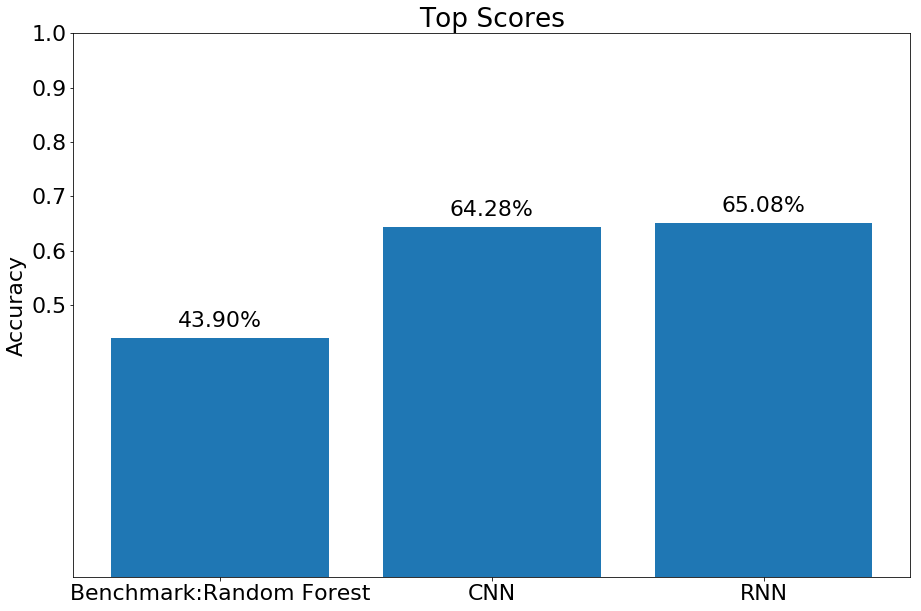

In [38]:
#Visualize results
from operator import itemgetter
best_benchmark = 'Benchmark:' + max(scores,key=itemgetter(1))[0]

labels = [best_benchmark, 'CNN', 'RNN']
acc = [max(scores,key=itemgetter(1))[1], cnn_eval[1], rnn_eval[1]]

plt.figure(figsize = (15, 10))
plt.bar(labels, acc)
for i in range(3):
    plt.text(labels[i], acc[i] + .02, ("%.2f" %(acc[i]*100)) +'%', ha='center')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(5, 11)], [i*10/100 for i in range(5, 11)])
plt.title('Top Scores')
plt.show()

In [39]:
# Inspect Top model performance 
top_models = {'rnn': rnn_model, 'cnn': cnn_model}
histories = {'rnn_hist': rnn_history, 'cnn_hist': cnn_history}
best = 'c' if cnn_eval[1] > rnn_eval[1] else 'r'
best_model = top_models[best+'nn']
best_model_hist = histories[best + 'nn_hist']
print('Top Model Type:' ,best.upper()+'NN')
best_model.summary()

Top Model Type: RNN
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 220, 100)          3361100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 220, 100)          60400     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'RNN Model Accuracy')

Text(0, 0.5, 'RNN Accuracy')

Text(0.5, 0, 'Epoch')

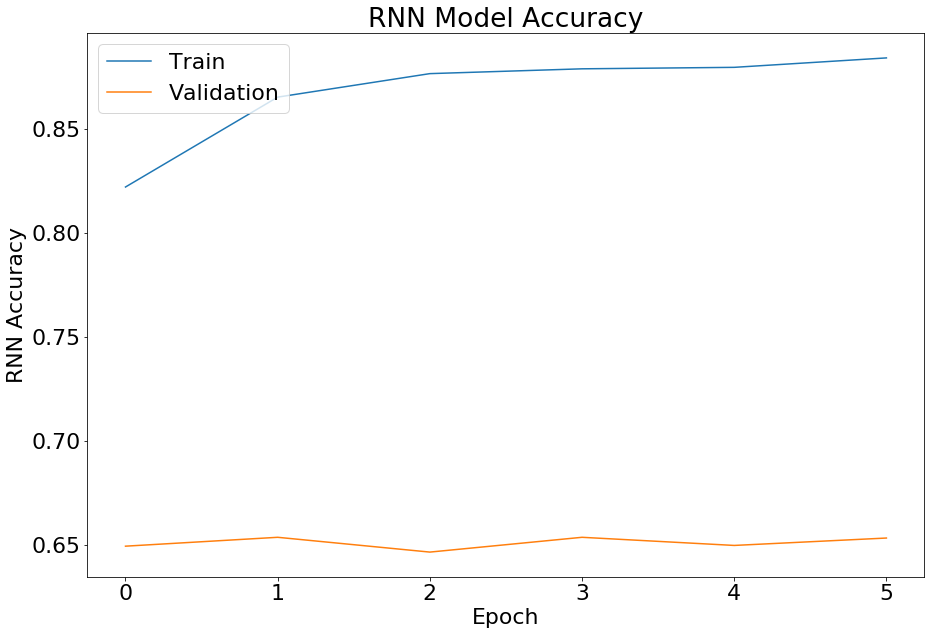

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'RNN Model Loss / Error')

Text(0, 0.5, 'RNN Loss / Error')

Text(0.5, 0, 'Epoch')

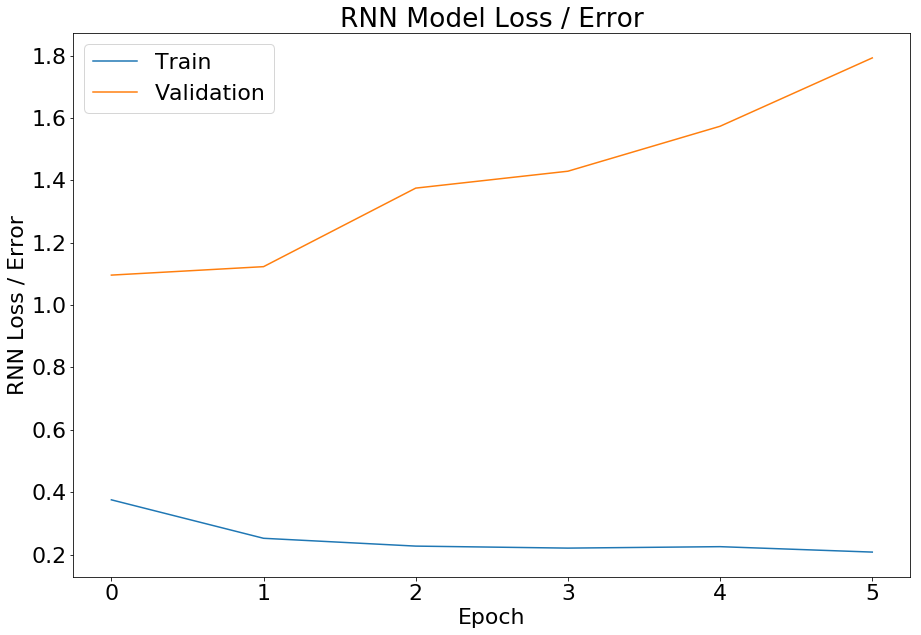

In [40]:
#Results history
# Display history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(best_model_hist.history['accuracy'])
plt.plot(best_model_hist.history['val_accuracy'])
plt.title(best.upper()+'NN Model Accuracy')
plt.ylabel(best.upper() + 'NN Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Display history for loss
plt.figure(figsize=(15, 10))
plt.plot(best_model_hist.history['loss'])
plt.plot(best_model_hist.history['val_loss'])
plt.title(best.upper() + 'NN Model Loss / Error')
plt.ylabel(best.upper() + 'NN Loss / Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
#Confusion matrix and prediction
from sklearn.metrics import confusion_matrix, f1_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "blue")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
F1 Score: 62.50


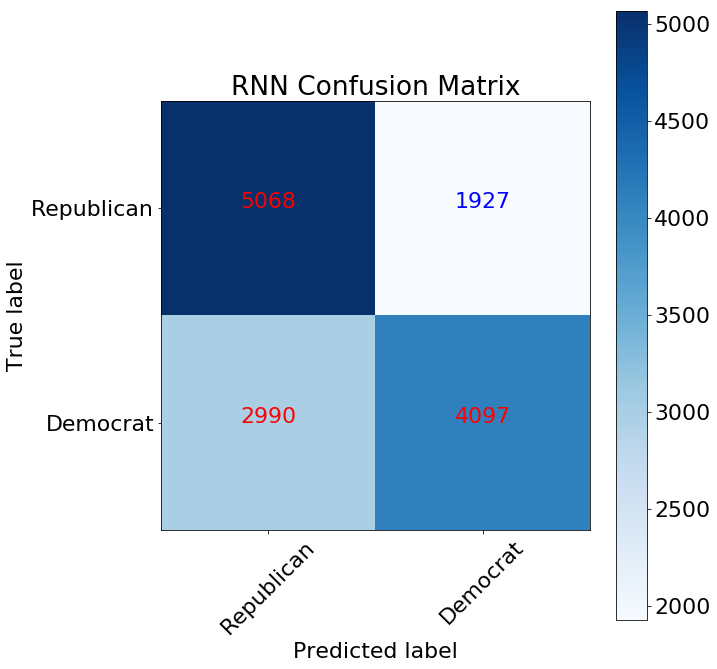

In [42]:
preds = np.argmax(best_model.predict(X_test), axis=1)
actual = np.argmax(y_test, axis=1)

cm = confusion_matrix(actual, preds)

#[1,0] = 0;[0,1] =1
#check y and target to confirm this
#(1,0) = Democrat
#(0,1) = Republican
#p1 = Repub. P2 = Democ

cm_plot_labels = ['Republican','Democrat']

plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title=best.title() +'NN Confusion Matrix')

print('F1 Score: ' "%.2f" %(f1_score(actual, preds)*100))

In [43]:
# Save all predictions to dataframe
preds_df = pd.DataFrame.from_dict({'Predictions': preds, 'Actual': actual})
preds_df = preds_df.join(X_test_text.reset_index(drop=True))

# Create column to indicate if the prediction matches the actual
# 0 = Clinton; 1 = Trump
preds_df['Accuracy'] = preds_df['Predictions'] == preds_df['Actual']
preds_df.head()

,Actual,Predictions,text,bigrams,Accuracy
0,0,0,"[madam, may, respond, thanking, senator, flori...","[madam, may, respond, thanking, senator, flori...",True
1,0,1,"[madam, rise, today, continue, weekly, practic...","[madam, rise, today, continue, weekly, practic...",False
2,1,1,"[ask, unanimous, consent, resolutions, agreed,...","[ask, unanimous, consent, resolutions, agreed,...",True
3,0,0,"[madam, intend, offer, following, motion, hr, ...","[madam, intend, offer, following, motion, hr, ...",True
4,1,0,"[today, wish, recognize, newark, oh, native, j...","[today, wish, recognize, newark, oh, native, j...",False


In [49]:
mylist = []
for chunk in  pd.read_csv('/home/asheshchoudhury/nytsections.csv', sep = ',',lineterminator = '\n',header=None, index_col=None,skiprows=700000,nrows = 1200000,chunksize=5000000):
    mylist.append(chunk)

allarticles_df = pd.concat(mylist, axis= 0)
del mylist
allarticles_df.columns = ['Date-YYYYMMDD', 'Catagory', 'content']
len(allarticles_df)
allarticles_df.head(5)
allarticles_df.tail(5)
allarticles_df['statement_length'] = allarticles_df['content'].str.len()
allarticles_df['statement_length'].describe()
#Take reasonable(>25 percentile, <75 percentile) statement length , else huge statment lengt will crash the system
statement_lenght_75_percentile = 6193
statement_lenght_25_percentile = 1318
allarticles_df = allarticles_df.loc[(allarticles_df['statement_length'] <= statement_lenght_75_percentile)]
allarticles_df = allarticles_df.loc[(allarticles_df['statement_length'] >= statement_lenght_25_percentile)]
allarticles_df['statement_length'].describe()
len(allarticles_df)

1110344

,Date-YYYYMMDD,Catagory,content
0,19941024,C,Fighting Laughing And Jiving By JENNIFER DUNN...
1,19941025,D,Adia Services Inc.(ADIANNM) reports earnings f...
2,19941002,2,The Master of Dramatic Truth By Stephen Holde...
3,19941025,D,Airborne Freight Corp.(ABFN) reports earnings ...
4,19941025,D,Allegheny Ludlum Corp.(ALSN) reports earnings ...


,Date-YYYYMMDD,Catagory,content
1110339,20070619,C,Liberating Effects of Captive Conversation By...
1110340,20070619,B,The City's New Motto: 'See You in Court' By C...
1110341,20070619,C,Test Driving an Air Taxi: Quiet Quick but Not ...
1110342,20070619,D,A Staple of the News Media But Is Rodriguez a ...
1110343,20070619,A,Corrections: For the Record Because of an edi...


count    1.110344e+06
mean     4.252672e+03
std      4.494076e+03
min      3.000000e+00
25%      1.321000e+03
50%      3.525000e+03
75%      6.098000e+03
max      2.265840e+05
Name: statement_length, dtype: float64

count    565546.000000
mean       3552.451114
std        1533.965748
min        1318.000000
25%        2018.000000
50%        3571.000000
75%        4949.000000
max        6193.000000
Name: statement_length, dtype: float64

565546

In [50]:
# Take selected number of records to test
no_of_records = len(allarticles_df)
no_of_records = 400000


In [51]:
test_df = allarticles_df.head(no_of_records)

In [52]:

clean_text = []
i = 0

for text in test_df['content']:
    i = i + 1
    # Remove accent characters => Expand Contractions => Remove special characters => Lammatize Text => Remove Stop Words
    no_accent_chars = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #expanded_text = expand_contractions(no_accent_chars)
    expanded_text = no_accent_chars 
    no_special_chars = remove_special_characters(expanded_text, remove_digits=False)
    #lem_text = lemmatize_text(no_special_chars)
    #filtered_text = remove_stopwords(lem_text)
    filtered_text = remove_stopwords(no_special_chars)
    
    # Make all text lowercase
    lowercase_text = filtered_text.lower()
    
    # Split text into list of words
    words = lowercase_text.split()
    clean_text.append(words)
    if (i%50000 == 0):
        print('Currently processing: %s of total %s records' %(i,no_of_records))

# Add cleaned text to dataframe
test_df['clean_content'] = clean_text


Currently processing: 50000 of total 400000 records
Currently processing: 100000 of total 400000 records
Currently processing: 150000 of total 400000 records
Currently processing: 200000 of total 400000 records
Currently processing: 250000 of total 400000 records
Currently processing: 300000 of total 400000 records
Currently processing: 350000 of total 400000 records
Currently processing: 400000 of total 400000 records


In [53]:
data = test_df['clean_content'].values
bigrams_data = []

j=0
for i in range(len(data)):
#    bigrams_data.append(bigrams[data[i]])
    bigrams_data.append([data[i]])
    j = j + 1
    if (j%50000 == 0):
        print('Currently processing: %s' %(j))
    
bigrams_data = np.array(bigrams_data)


Currently processing: 50000
Currently processing: 100000
Currently processing: 150000
Currently processing: 200000
Currently processing: 250000
Currently processing: 300000
Currently processing: 350000
Currently processing: 400000


In [54]:
bigrams_joined = []
i = 0
for a in bigrams_data:
    for b in a:
        i = i + 1
        if (i%50000 == 0):
            print('Currently processing: %s' %(i))
        bigrams_joined.append(' '.join(b))

# Remove underscore from filters and no need to convert to lowercase
#tokenizer = text.Tokenizer(filters='!"#%&()*+,./:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(bigrams_joined)
sequences = tokenizer.texts_to_sequences(bigrams_joined)

word_index = tokenizer.word_index
print('Total Words in Vocabulary: {}' .format(len(word_index)))

Currently processing: 50000
Currently processing: 100000
Currently processing: 150000
Currently processing: 200000
Currently processing: 250000
Currently processing: 300000
Currently processing: 350000
Currently processing: 400000
Total Words in Vocabulary: 841671


In [55]:
X_t = pad_sequences(sequences, maxlen=max_len, padding='post')
X_t_df = pd.DataFrame(X_t)
#X_t_df['bigrams'] = bigrams_data
#X_t_df['text'] = df.reset_index(drop=True)['clean_tweet']
len(X_t_df)

400000

In [56]:
X_t_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
399995,12532,18514,4114,1822,204,2481,580,2481,580,869,...,81115,347046,2491,2481,580,204,233,204,233,0
399996,4314,12222,296215,1432,2057,2481,580,2481,580,869,...,0,0,0,0,0,0,0,0,0,0
399997,7334,15545,2269,8906,2481,580,2445,49910,9916,3401,...,0,0,0,0,0,0,0,0,0,0
399998,110591,1688,2219,3270,4026,26521,5169,3653,10427,2529,...,5,1381,7351,3482,223,17819,204,233,204,233
399999,989,2325,989,7207,2481,580,2481,580,869,452,...,0,0,0,0,0,0,0,0,0,0


In [57]:
a = X_t_df.shape[0]
b = X_t_df.shape[1]

In [58]:
best_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 220)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 220, 100)          3361100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 220, 100)          60400     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0  

In [59]:
#Print the lenght of embedding length
embed_len = (best_model.get_weights()[0]).shape[0]

In [60]:
#Ensure the maximun embedding lenght of training set retains in test set.
X_t_df = np.where(X_t_df >= embed_len, embed_len-1, X_t_df) 

In [61]:
#Predict Political Afflication
political_affliation_pred_D0_R1 = np.argmax(rnn_model.predict(X_t_df), axis=1)
political_affliation_pred_D0_R1

array([0, 1, 0, ..., 0, 1, 0])

In [62]:
# Predict Political leaning (proxy of Bias)
political_affliation_measure=rnn_model.predict(X_t_df)

In [111]:
#Append Political Leaning in DF
democrat_affliation = []
republican_affliation = []
for i in range(len(X_t_df)):
    democrat_affliation.append(political_affliation_measure[i][0])
    republican_affliation.append(political_affliation_measure[i][1])   

In [112]:
test_df['political_affliation_pred_D0_R1'] = political_affliation_pred_D0_R1
test_df['democrat_affliation'] = democrat_affliation
test_df['republican_affliation'] = republican_affliation
#Filter out absolute extreme(<0.2,>0.8) values as they are most probably  result of word presence than true affliations 
LL = 0.2
UL = 0.8
test_df = test_df.loc[(test_df['republican_affliation'] > LL) & (test_df['republican_affliation'] < UL)]



ValueError: Length of values does not match length of index

In [ ]:
#check out some borderline samples
test_df.loc[(test_df['republican_affliation'] > 0.40) & (test_df['republican_affliation'] < 0.60)].head(4)
test_df['political_affliation_pred_D0_R1'].describe()

In [ ]:
Catagory = test_df['Catagory'].unique()

In [ ]:
Republican_affliation =[]
Catagory_news = []
Republican_1_or_Democrat_0_classification =[]

for i in Catagory:
    Catagory_news.append(i)
    Republican_affliation.append("%.1f" %(test_df.loc[test_df['Catagory'] == i]['republican_affliation'].mean()*100))
    Republican_1_or_Democrat_0_classification.append("%.1f" %(test_df.loc[test_df['Catagory'] == i]['political_affliation_pred_D0_R1'].mean()*100))
    #"%.2f" %(f1_score(actual, preds)*100))
    #print("%.1f" %(test_df.loc[test_df['publication'] == i]['republican_affliation'].mean()*100))

In [ ]:
Catagory_news

In [ ]:
Republican_affliation

In [79]:
#Divide/Select Sections
#NYT_df = test_df.loc[test_df['Catagory'].isin(['W','CY'])]
NYT_df = test_df
NYT_republican_affliation_df = NYT_df['republican_affliation']
NYT_df.head(5)

,Date-YYYYMMDD,Catagory,content,statement_length,clean_content,political_affliation_pred_D0_R1,democrat_affliation,republican_affliation
95,19941002,7,Matt Scudder Is Sober Now By David Willis McC...,6131,"[matt, scudder, sober, david, willis, mccullou...",1,0.286384,0.713616
110,19941025,A,Israelis Look To Clinton Trip For Progress Wit...,4448,"[israelis, look, clinton, trip, progress, syri...",0,0.772807,0.227193
127,19941025,A,Cedras's New Palace: 2 Bedrooms Personal Compu...,3632,"[cedrass, new, palace, 2, bedrooms, personal, ...",0,0.659243,0.340757
188,19941002,5,South Africa To the Editor: Having recently v...,2434,"[south, africa, editor, recently, visited, cap...",1,0.360772,0.639228
201,19941002,1,Jill L. Kraft Robert G. Butler Dr. Jill Laure...,1740,"[jill, l, kraft, robert, g, butler, dr, jill, ...",0,0.655360,0.344640


In [80]:
Repub_affl_between_0_and_10= len(NYT_df.loc[(NYT_df['republican_affliation'] > 0) & (NYT_df['republican_affliation'] < 0.1)])
Repub_affl_between_10_and_20=len(NYT_df.loc[(NYT_df['republican_affliation'] > .1) & (NYT_df['republican_affliation'] < 0.2)])
Repub_affl_between_20_and_30=len(NYT_df.loc[(NYT_df['republican_affliation'] > .2) & (NYT_df['republican_affliation'] < 0.3)])
Repub_affl_between_30_and_40=len(NYT_df.loc[(NYT_df['republican_affliation'] > .3) & (NYT_df['republican_affliation'] < 0.4)])
Repub_affl_between_40_and_50=len(NYT_df.loc[(NYT_df['republican_affliation'] > .4) & (NYT_df['republican_affliation'] < 0.5)])
Repub_affl_between_50_and_60=len(NYT_df.loc[(NYT_df['republican_affliation'] > .5) & (NYT_df['republican_affliation'] < 0.6)])
Repub_affl_between_60_and_70=len(NYT_df.loc[(NYT_df['republican_affliation'] > .6) & (NYT_df['republican_affliation'] < 0.7)])
Repub_affl_between_70_and_80=len(NYT_df.loc[(NYT_df['republican_affliation'] > .7) & (NYT_df['republican_affliation'] < 0.8)])
Repub_affl_between_80_and_90=len(NYT_df.loc[(NYT_df['republican_affliation'] > .8) & (NYT_df['republican_affliation'] < 0.9)])
Repub_affl_between_90_and_100=len(NYT_df.loc[(NYT_df['republican_affliation'] > .9) & (NYT_df['republican_affliation'] < 1.0)])

In [81]:
Repub_affl_between_0_and_10
Repub_affl_between_10_and_20
Repub_affl_between_20_and_30
Repub_affl_between_30_and_40
Repub_affl_between_40_and_50
Repub_affl_between_50_and_60
Repub_affl_between_60_and_70
Repub_affl_between_70_and_80
Repub_affl_between_80_and_90
Repub_affl_between_90_and_100

0

0

4583

3805

3436

3536

3802

4430

0

0

<Figure size 1080x360 with 0 Axes>

Text(1, 0.1, '0')

Text(1, 1.1, '0')

Text(4584, 2.1, '4583')

Text(3806, 3.1, '3805')

Text(3437, 4.1, '3436')

Text(3537, 5.1, '3536')

Text(3803, 6.1, '3802')

Text(4431, 7.1, '4430')

Text(1, 8.1, '0')

Text(1, 9.1, '0')

<BarContainer object of 10 artists>

Text(0.5, 0, 'No. of NYT articles')

Text(0, 0.5, 'Republican affliciation scores')

Text(0.5, 1.0, 'No. of NYT articles in each Republican affiliation(D0,R1) score range')

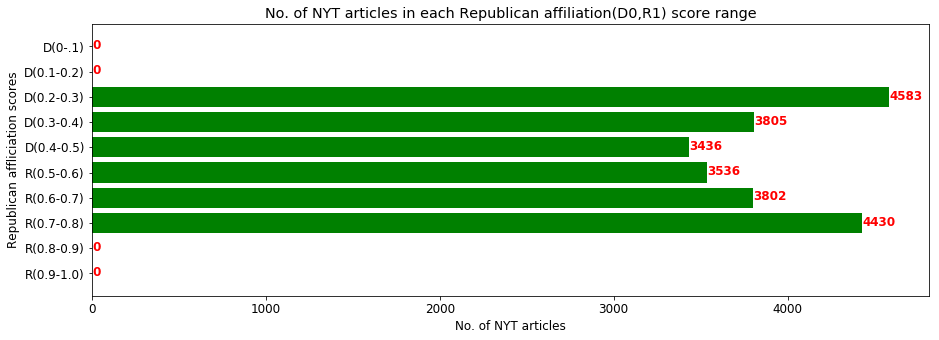

<Figure size 1080x360 with 0 Axes>

In [82]:
Republican_affln = [Repub_affl_between_0_and_10,Repub_affl_between_10_and_20,Repub_affl_between_20_and_30,Repub_affl_between_30_and_40,Repub_affl_between_40_and_50,Repub_affl_between_50_and_60,Repub_affl_between_60_and_70,Repub_affl_between_70_and_80,Repub_affl_between_80_and_90,Repub_affl_between_90_and_100]
Political_affln = ['D(0-.1)','D(0.1-0.2)','D(0.2-0.3)','D(0.3-0.4)','D(0.4-0.5)','R(0.5-0.6)','R(0.6-0.7)','R(0.7-0.8)','R(0.8-0.9)','R(0.9-1.0)']

#N = 10
#width = 0.1
#ind = np.arange(N)  # the x locations for the groups

fig = plt.figure(figsize = (15, 5))
plt.figure(figsize = (15, 5))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)

for i, v in enumerate(Republican_affln):
    ax.text(v + 1, i + 0.1, str(v), color='red', fontweight='bold')

ax.barh(Political_affln, Republican_affln, align='center',color = 'green')
ax.set_yticks(Political_affln)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('No. of NYT articles')
ax.set_ylabel('Republican affliciation scores')
ax.set_title('No. of NYT articles in each Republican affiliation(D0,R1) score range')

plt.show()

<Figure size 1080x360 with 0 Axes>

Text(11825, 0.1, '11824')

Text(11769, 1.1, '11768')

<BarContainer object of 2 artists>

Text(0.5, 0, 'No. of NYT articles')

Text(0, 0.5, 'Republican affliciation scores')

Text(0.5, 1.0, 'Democrat vs. Republican NYT articles in (0.1,0.9) score range')

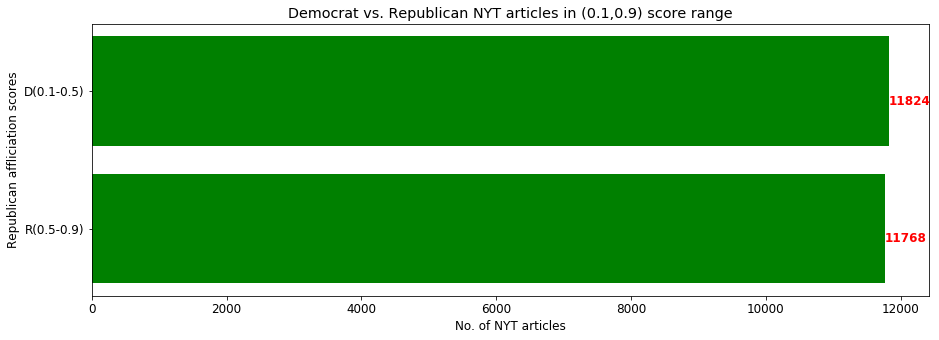

<Figure size 1080x360 with 0 Axes>

In [83]:
Republican_affln = [Repub_affl_between_10_and_20 + Repub_affl_between_20_and_30 + Repub_affl_between_30_and_40 + Repub_affl_between_40_and_50,Repub_affl_between_50_and_60 + Repub_affl_between_60_and_70 + Repub_affl_between_70_and_80 + Repub_affl_between_80_and_90]
Political_affln = ['D(0.1-0.5)','R(0.5-0.9)']

#N = 10
#width = 0.1
#ind = np.arange(N)  # the x locations for the groups

fig = plt.figure(figsize = (15, 5))
plt.figure(figsize = (15, 5))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)

for i, v in enumerate(Republican_affln):
    ax.text(v + 1, i + 0.1, str(v), color='red', fontweight='bold')

ax.barh(Political_affln, Republican_affln, align='center',color = 'green')
ax.set_yticks(Political_affln)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('No. of NYT articles')
ax.set_ylabel('Republican affliciation scores')
ax.set_title('Democrat vs. Republican NYT articles in (0.1,0.9) score range')

plt.show()

In [84]:
#LL = 0.3
#UL = 0.7
#Breitbart_Republican_share = Breitbart_df.loc[(Breitbart_df['republican_affliation'] > LL) & (Breitbart_df['republican_affliation'] < UL)]['republican_affliation'].median()
#CNN_Republican_share = CNN_df.loc[(CNN_df['republican_affliation'] > LL) & (CNN_df['republican_affliation'] < UL)]['republican_affliation'].median()
#Fox_Republican_share = Fox_df.loc[(Fox_df['republican_affliation'] > LL) & (Fox_df['republican_affliation'] < UL)]['republican_affliation'].median()
#Washington_Post_Republican_share = Washington_Post_df.loc[(Washington_Post_df['republican_affliation'] > LL) & (Washington_Post_df['republican_affliation'] < UL)]['republican_affliation'].median()
#NYT_Republican_share = NYT_df.loc[(NYT_df['republican_affliation'] > LL) & (NYT_df['republican_affliation'] < UL)]['republican_affliation'].median()


In [85]:
#Filter out absolute extreme(<0.2,>0.8) values as they are most probably  result of word presence than true affliations 
LL = 0.2
UL = 0.8
NYT_df = NYT_df.loc[(NYT_df['republican_affliation'] > LL) & (NYT_df['republican_affliation'] < UL)]


In [86]:
path_to_file = '/home/asheshchoudhury/outputfile.csv'
export_csv = NYT_df.to_csv (path_to_file, index = None, header=True) 


In [87]:
NYT_df.head(5)

,Date-YYYYMMDD,Catagory,content,statement_length,clean_content,political_affliation_pred_D0_R1,democrat_affliation,republican_affliation
95,19941002,7,Matt Scudder Is Sober Now By David Willis McC...,6131,"[matt, scudder, sober, david, willis, mccullou...",1,0.286384,0.713616
110,19941025,A,Israelis Look To Clinton Trip For Progress Wit...,4448,"[israelis, look, clinton, trip, progress, syri...",0,0.772807,0.227193
127,19941025,A,Cedras's New Palace: 2 Bedrooms Personal Compu...,3632,"[cedrass, new, palace, 2, bedrooms, personal, ...",0,0.659243,0.340757
188,19941002,5,South Africa To the Editor: Having recently v...,2434,"[south, africa, editor, recently, visited, cap...",1,0.360772,0.639228
201,19941002,1,Jill L. Kraft Robert G. Butler Dr. Jill Laure...,1740,"[jill, l, kraft, robert, g, butler, dr, jill, ...",0,0.655360,0.344640


In [88]:
NYT_all_coloumn_df = NYT_df
NYT_df['datetime'] = pd.to_datetime(NYT_df['Date-YYYYMMDD'],format='%Y%m%d', errors='ignore')
NYT_df = NYT_df.set_index('datetime')
NYT_df.drop(['Date-YYYYMMDD','Catagory','content','clean_content','political_affliation_pred_D0_R1','democrat_affliation'], axis=1, inplace=True)
NYT_df.head()

,statement_length,republican_affliation
datetime,,
1994-10-02,6131,0.713616
1994-10-25,4448,0.227193
1994-10-25,3632,0.340757
1994-10-02,2434,0.639228
1994-10-02,1740,0.344640


In [89]:
#Take monthly mean of Republican afflition
NYT_monthlymean_df = NYT_df.resample('M').mean()
NYT_monthlymean_df.head()

,statement_length,republican_affliation
datetime,,
1994-10-31,3651.779736,0.504367
1994-11-30,NaN,NaN
1994-12-31,3790.190045,0.494191
1995-01-31,3677.195556,0.483758
1995-02-28,3718.264249,0.487902


In [90]:
NYT_monthlymean_df['Date'] = NYT_monthlymean_df.index.date
NYT_monthlymean_df['Year'] = NYT_monthlymean_df.index.year
NYT_monthlymean_df['Month'] = NYT_monthlymean_df.index.month
NYT_monthlymean_df['Day'] = NYT_monthlymean_df.index.day
NYT_monthlymean_df['Weekday']= NYT_monthlymean_df.index.weekday_name
#NYT_monthlymean_df.tail()
NYT_monthlymean_df.to_csv('/home/asheshchoudhury/NYT_monthlymean_backup_df.csv',index=False,header = True)
NYT_monthlymean_df['Year_Month']= NYT_monthlymean_df.Year.astype(str) + '-'+ NYT_monthlymean_df.Month.astype(str)  
NYT_monthlymean_df['NYT_republican_affliation'] = NYT_monthlymean_df['republican_affliation']
NYT_monthlymean_df.drop(['Date','Year','Month','Day','Weekday','republican_affliation'], axis=1, inplace=True)
NYT_monthlymean_df.tail()


,statement_length,Year_Month,NYT_republican_affliation
datetime,,,
2003-05-31,3779.291667,2003-5,0.521410
2003-06-30,3576.141129,2003-6,0.521258
2003-07-31,3867.138095,2003-7,0.492237
2003-08-31,3517.913706,2003-8,0.488269
2003-09-30,3581.800000,2003-9,0.536109


In [91]:
#Take yearly mean of Republican afflition
NYT_yearlymean_df = NYT_df.resample('Y').mean()
NYT_yearlymean_df.head()

,statement_length,republican_affliation
datetime,,
1994-12-31,3720.058036,0.499347
1995-12-31,3657.668703,0.494864
1996-12-31,3606.742857,0.500714
1997-12-31,3694.135208,0.498138
1998-12-31,3727.374245,0.500453


<Figure size 720x360 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0.5, 1.0, 'Average Republican Affliation trend')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'NYT monthly mean Republican Affliation')

<Figure size 720x360 with 0 Axes>

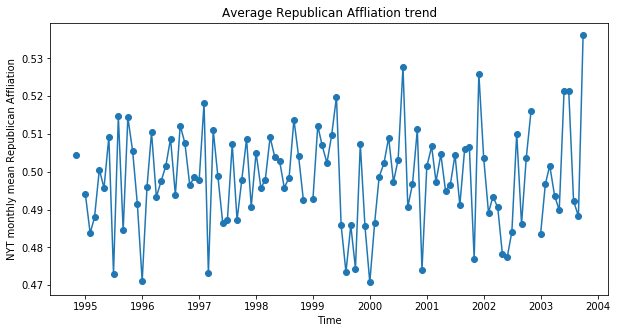

In [92]:
start = '1994'
end = '2008'
fig = plt.figure(figsize = (10, 5))
plt.figure(figsize = (10, 5))
plt.rcParams.update({'font.size': 10})

plt.plot(NYT_monthlymean_df.loc[start:end, 'NYT_republican_affliation'], marker='o', linestyle='-')
plt.title('Average Republican Affliation trend')
plt.xlabel('Time', fontsize=10)
plt.ylabel('NYT monthly mean Republican Affliation', fontsize=10)

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))



In [93]:
#Take Quarterly mean of Republican afflition
NYT_quarterlymean_df = NYT_df.resample('Q').mean()
NYT_quarterlymean_df.head()

,statement_length,republican_affliation
datetime,,
1994-12-31,3720.058036,0.499347
1995-03-31,3731.918033,0.490367
1995-06-30,3773.259084,0.493726
1995-09-30,3648.406957,0.505247
1995-12-31,3540.430052,0.492268


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Average Republican Affliation trend')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'NYT quarterlyly mean Republican Affliation')

<Figure size 720x360 with 0 Axes>

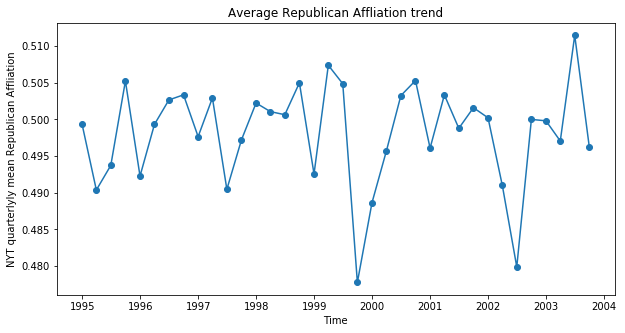

In [94]:
start = '1994'
end = '2008'
fig = plt.figure(figsize = (10, 5))
plt.figure(figsize = (10, 5))
plt.rcParams.update({'font.size': 10})

plt.plot(NYT_quarterlymean_df.loc[start:end, 'republican_affliation'], marker='o', linestyle='-')
plt.title('Average Republican Affliation trend')
plt.xlabel('Time', fontsize=10)
plt.ylabel('NYT quarterlyly mean Republican Affliation', fontsize=10)

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))



<Figure size 1440x360 with 0 Axes>

,statement_length,republican_affliation,Date,Year,Month,Day,Weekday,Quarter,Year_Month
datetime,,,,,,,,,
2003-09-26,NaN,NaN,2003-09-26,2003,9,26,Friday,2003Q3,2003-9
2003-09-27,NaN,NaN,2003-09-27,2003,9,27,Saturday,2003Q3,2003-9
2003-09-28,3126.166667,0.545772,2003-09-28,2003,9,28,Sunday,2003Q3,2003-9
2003-09-29,3947.714286,0.530785,2003-09-29,2003,9,29,Monday,2003Q3,2003-9
2003-09-30,3612.900000,0.592358,2003-09-30,2003,9,30,Tuesday,2003Q3,2003-9


Text(0.5, 1.0, 'Range of Republican Affliations in NYT')

Text(0, 0.5, 'Daily Republican Affliations in NYT ')

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

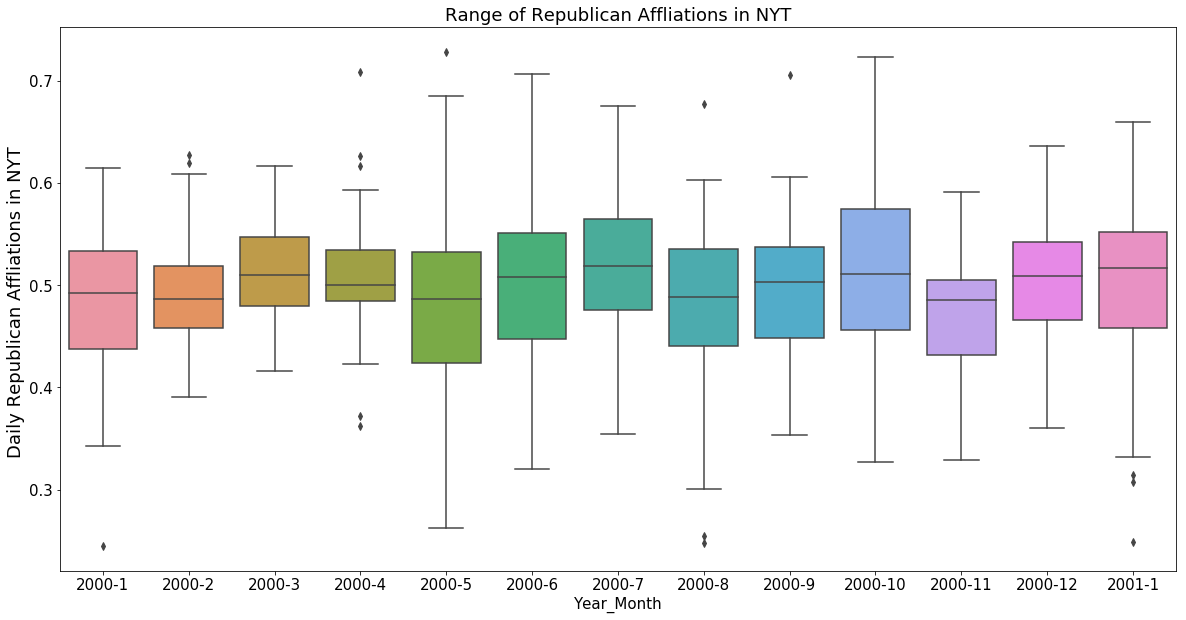

In [122]:
#Bar plot for monthly range of daily Republican affliations
fig = plt.figure(figsize = (20, 5))
plt.figure(figsize = (20, 5))
plt.rcParams.update({'font.size': 15})
NYT_dailymean_df = NYT_df.resample('D').mean()
NYT_dailymean_df['Date'] = NYT_dailymean_df.index.date
NYT_dailymean_df['Year'] = NYT_dailymean_df.index.year
NYT_dailymean_df['Month'] = NYT_dailymean_df.index.month
NYT_dailymean_df['Day'] = NYT_dailymean_df.index.day
NYT_dailymean_df['Weekday']= NYT_dailymean_df.index.weekday_name
NYT_dailymean_df['Quarter'] = NYT_dailymean_df.index.to_period("Q")
NYT_dailymean_df['Year_Month']= df['var3'] = NYT_dailymean_df.Year.astype(str) + '-'+ NYT_dailymean_df.Month.astype(str)  
NYT_dailymean_df['republican_affliation'] = NYT_dailymean_df['republican_affliation']
NYT_dailymean_df.tail()
ax = plt.figure(figsize=(20,10))
sns.boxplot(data=NYT_dailymean_df.loc['2000-01':'2001-01'], x='Year_Month', y='republican_affliation');
#ax.set_title('tt')
plt.title('Range of Republican Affliations in NYT' , fontsize =18)
#plt.xlabel('Time', fontsize=18)
plt.ylabel('Daily Republican Affliations in NYT ', fontsize=18)
#####################Yearly Seasonality##############################################





Text(0.5, 1.0, 'Range of Republican Affliations in NYT')

Text(0, 0.5, 'Daily Republican Affliations in NYT ')

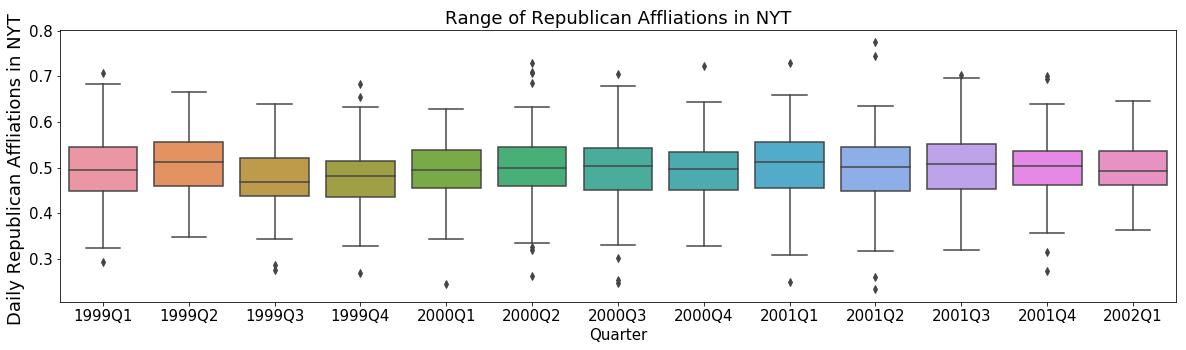

In [116]:
ax = plt.figure(figsize=(20,5))
sns.boxplot(data=NYT_dailymean_df.loc['1999-01':'2002-01'], x='Quarter', y='republican_affliation');
#ax.set_title('tt')
plt.title('Range of Republican Affliations in NYT' , fontsize =18)
#plt.xlabel('Time', fontsize=18)
plt.ylabel('Daily Republican Affliations in NYT ', fontsize=18)


Text(0.5, 1.0, 'Range of Republican Affliations in NYT')

Text(0, 0.5, 'Daily Republican Affliations in NYT ')

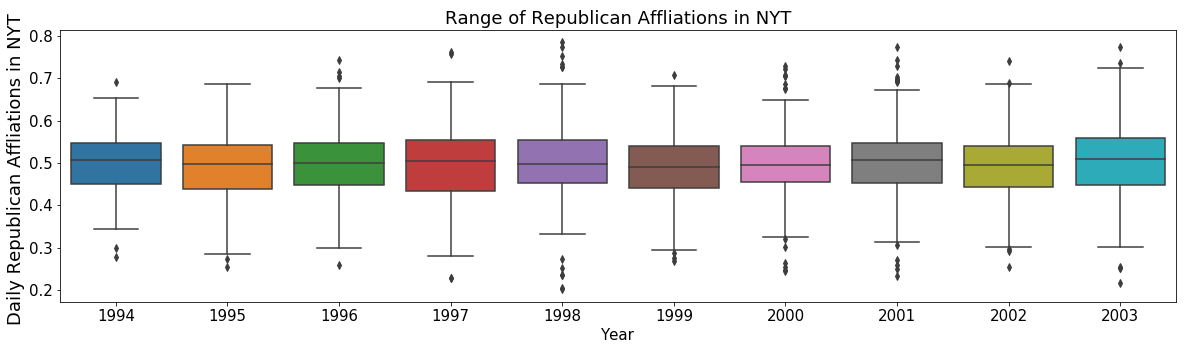

In [117]:
ax = plt.figure(figsize=(20,5))
sns.boxplot(data=NYT_dailymean_df.loc['1994-01':'2008-01'], x='Year', y='republican_affliation');
#ax.set_title('tt')
plt.title('Range of Republican Affliations in NYT' , fontsize =18)
#plt.xlabel('Time', fontsize=18)
plt.ylabel('Daily Republican Affliations in NYT ', fontsize=18)


Text(0.5, 1.0, 'Range of Republican Affliations in NYT')

Text(0, 0.5, 'Daily Republican Affliations in NYT ')

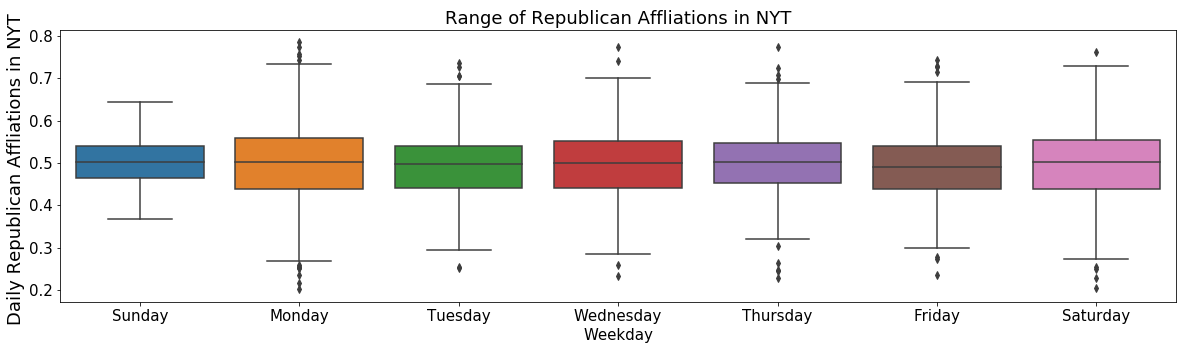

In [118]:
ax = plt.figure(figsize=(20,5))
sns.boxplot(data=NYT_dailymean_df.loc['1994-01':'2008-01'], x='Weekday', y='republican_affliation');
#ax.set_title('tt')
plt.title('Range of Republican Affliations in NYT' , fontsize =18)
#plt.xlabel('Time', fontsize=18)
plt.ylabel('Daily Republican Affliations in NYT ', fontsize=18)


<Figure size 1440x360 with 0 Axes>

,statement_length,republican_affliation,Date,Year,Month,Day,Weekday,Year_Month
datetime,,,,,,,,
2002-09-30,3893.504777,0.500004,2002-09-30,2002,9,30,Monday,2002-9
2002-12-31,3821.627329,0.499808,2002-12-31,2002,12,31,Tuesday,2002-12
2003-03-31,3834.716667,0.497054,2003-03-31,2003,3,31,Monday,2003-3
2003-06-30,3752.693333,0.511477,2003-06-30,2003,6,30,Monday,2003-6
2003-09-30,3683.160600,0.496200,2003-09-30,2003,9,30,Tuesday,2003-9


Text(0.5, 1.0, 'Range of Monthly Republican Affliations in NYT')

Text(0, 0.5, 'Monthly Republican Affliations in NYT ')

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

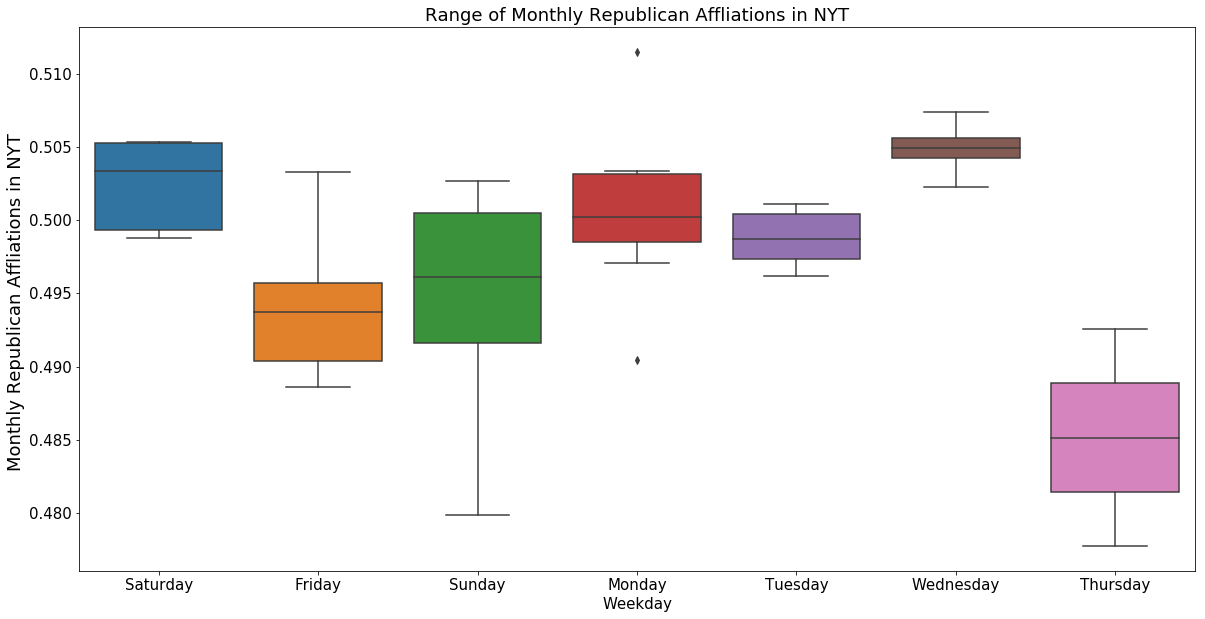

In [119]:
#Bar plot for monthly range of daily Republican affliations
fig = plt.figure(figsize = (20, 5))
plt.figure(figsize = (20, 5))
plt.rcParams.update({'font.size': 15})
NYT_monthlymean_df = NYT_df.resample('Q').mean()
NYT_monthlymean_df['Date'] = NYT_monthlymean_df.index.date
NYT_monthlymean_df['Year'] = NYT_monthlymean_df.index.year
NYT_monthlymean_df['Month'] = NYT_monthlymean_df.index.month
NYT_monthlymean_df['Day'] = NYT_monthlymean_df.index.day
NYT_monthlymean_df['Weekday']= NYT_monthlymean_df.index.weekday_name
NYT_monthlymean_df['Year_Month']= df['var3'] = NYT_monthlymean_df.Year.astype(str) + '-'+ NYT_monthlymean_df.Month.astype(str)  
NYT_monthlymean_df['republican_affliation'] = NYT_monthlymean_df['republican_affliation']
NYT_monthlymean_df.tail()
ax = plt.figure(figsize=(20,10))
sns.boxplot(data=NYT_monthlymean_df.loc['1994-01':'2007-08'], x='Weekday', y='republican_affliation');
#ax.set_title('tt')
plt.title('Range of Monthly Republican Affliations in NYT' , fontsize =18)
#plt.xlabel('Time', fontsize=18)
plt.ylabel('Monthly Republican Affliations in NYT ', fontsize=18)
#####################Yearly Seasonality##############################################
